In [1]:
import pandas as pd
import numpy as np
import json
file_path = "AMAZON_FASHION_5.json"

reviews = []
with open(file_path, "r") as file:
    for line in file:
        reviews.append(json.loads(line))

df = pd.DataFrame.from_dict(reviews)

In [2]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue/Orange'}",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
1,5.0,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Black (3746...",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
2,5.0,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue/Gray L...",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
3,5.0,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue (37867...",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
4,5.0,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue/Pink'}",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN


In [3]:
df  = df[['overall', 'reviewText']]

In [4]:
selected_reviews = df[df['reviewText'].str.split().str.len() > 100].head(50)


In [5]:
selected_reviews.head()

,overall,reviewText
167,5.0,Great shoe. I've had Nike's before and have al...
204,4.0,Very good overall.\nNow Ive been a huge Sketch...
208,5.0,Glad I read the reviews and ordered a half siz...
210,5.0,"I love these, I had the previous iteration (or..."
211,5.0,"Super light-weight, decent arch support (mine ..."


In [6]:
selected_reviews['reviewLength'] = selected_reviews['reviewText'].apply(lambda x: len(x.split()))


In [7]:
selected_reviews['reviewLength'].describe()

count     50.000000
mean     153.400000
std       45.598514
min      102.000000
25%      123.000000
50%      149.000000
75%      162.000000
max      272.000000
Name: reviewLength, dtype: float64

<Axes: >

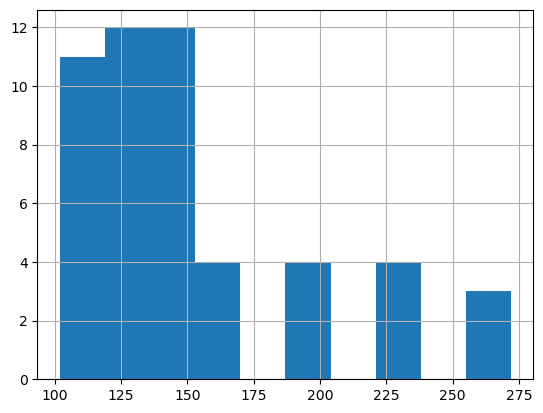

In [8]:
selected_reviews['reviewLength'].hist()

In [9]:
selected_reviews['reviewText'].head(5)

167    Great shoe. I've had Nike's before and have al...
204    Very good overall.\nNow Ive been a huge Sketch...
208    Glad I read the reviews and ordered a half siz...
210    I love these, I had the previous iteration (or...
211    Super light-weight, decent arch support (mine ...
Name: reviewText, dtype: object

In [10]:
from transformers import pipeline

# Load the pre-trained LLM model for summarization
model_t5 = pipeline("summarization", model="t5-base", tokenizer="t5-base")

# Function to summarize the reviews and convert to 50 words length
def summarize_reviews_t5(reviews):
    summaries = []
    for review in reviews:
        summary = model_t5(review, max_length=50, min_length=50, do_sample=False)[0]['summary_text']
        summaries.append(summary)
    return summaries



c:\Users\gitan\anaconda3\Lib\site-packages\transformers\models\t5\tokenization_t5_fast.py:160: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [11]:
# Usage
reviews = selected_reviews['reviewText'].astype('U').tolist()
summaries_t5 = summarize_reviews_t5(reviews)


In [12]:
summaries_t5[0]

"i've had Nike's before and have always been pleased with the comfort, performance, and quality . but this was the first time i ordered a pair online without trying them on first, so I was nervous ."

In [13]:
selected_reviews['summary_t5'] = summaries_t5
selected_reviews['summary_t5_length'] = selected_reviews['summary_t5'].apply(lambda x: len(x.split()))

In [14]:
selected_reviews.head()

,overall,reviewText,reviewLength,summary_t5,summary_t5_length
167,5.0,Great shoe. I've had Nike's before and have al...,133,i've had Nike's before and have always been pl...,37
204,4.0,Very good overall.\nNow Ive been a huge Sketch...,162,the sketchers go walk shoes are very sturdy an...,36
208,5.0,Glad I read the reviews and ordered a half siz...,123,I am a Beach Body Coach and these are now my f...,45
210,5.0,"I love these, I had the previous iteration (or...",130,this is definitely a light-weight training sho...,39
211,5.0,"Super light-weight, decent arch support (mine ...",188,i was pleasantly surprised by the sole/tread o...,38


In [15]:
from tabulate import tabulate

table_data = selected_reviews[['reviewText', 'summary_t5']].head(5).reset_index(drop=True).values.tolist()
table_headers = ['Index', 'reviewText', 'summary_t5']

print(tabulate(table_data, headers=table_headers, showindex=True))


  Index  reviewText                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [16]:
from transformers import pipeline, BartForConditionalGeneration, BartTokenizer

# Load the pre-trained BART model for summarization
model_bart = BartForConditionalGeneration.from_pretrained("facebook/bart-base")
tokenizer_bart = BartTokenizer.from_pretrained("facebook/bart-base")

def summarize_reviews_bart(reviews):
    summaries = []
    for review in reviews:
        inputs = tokenizer_bart.encode(review, return_tensors="pt", max_length=1024, truncation=True)
        summary_ids = model_bart.generate(inputs, max_length=50, min_length=50, num_beams=4, early_stopping=True)
        summary = tokenizer_bart.decode(summary_ids[0], skip_special_tokens=True)
        summaries.append(summary)
    return summaries


In [17]:
summaries_bart = summarize_reviews_bart(reviews)

In [18]:
summaries_bart[0]

"Great shoe. I've had Nike's before and have always been pleased with the comfort, performance, and quality. Though I will say this was the first time I ordered a pair online without trying them on first, so I was nervous"

In [19]:
selected_reviews['summary_bart'] = summaries_bart
selected_reviews['summary_bart_length'] = selected_reviews['summary_bart'].apply(lambda x: len(x.split()))

In [20]:
selected_reviews.head()

,overall,reviewText,reviewLength,summary_t5,summary_t5_length,summary_bart,summary_bart_length
167,5.0,Great shoe. I've had Nike's before and have al...,133,i've had Nike's before and have always been pl...,37,Great shoe. I've had Nike's before and have al...,40
204,4.0,Very good overall.\nNow Ive been a huge Sketch...,162,the sketchers go walk shoes are very sturdy an...,36,Very good overall. I would not get them to do ...,39
208,5.0,Glad I read the reviews and ordered a half siz...,123,I am a Beach Body Coach and these are now my f...,45,Glad I read the reviews and ordered a half siz...,41
210,5.0,"I love these, I had the previous iteration (or...",130,this is definitely a light-weight training sho...,39,"I love these, I had the previous iteration (or...",40
211,5.0,"Super light-weight, decent arch support (mine ...",188,i was pleasantly surprised by the sole/tread o...,38,"Super light-weight, decent arch support (mine ...",34


In [21]:
from tabulate import tabulate

table_data = selected_reviews[['reviewText', 'summary_bart']].head(5).reset_index(drop=True).values.tolist()
table_headers = ['Index', 'reviewText', 'summary_bart']

print(tabulate(table_data, headers=table_headers, showindex=True))


  Index  reviewText                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [22]:
from tabulate import tabulate

table_data = selected_reviews[['summary_t5', 'summary_bart']].head(5).reset_index(drop=True).values.tolist()
table_headers = ['Index', 'summary_t5', 'summary_bart']

print(tabulate(table_data, headers=table_headers, showindex=True))

  Index  summary_t5                                                                                                                                                                                                      summary_bart
-------  --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------  ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
      0  i've had Nike's before and have always been pleased with the comfort, performance, and quality . but this was the first time i ordered a pair online without trying them on first, so I was nervous .           Great shoe. I've had Nike's before and have always been pleased with the comfort, performance, and quality. Though 

In [23]:
from tabulate import tabulate

table_data = selected_reviews[['reviewLength','summary_t5_length', 'summary_bart_length']].head(5).reset_index(drop=True).values.tolist()
table_headers = ['Index', 'reviewLength','summary_t5_length', 'summary_bart_length']

print(tabulate(table_data, headers=table_headers, showindex=True))

  Index    reviewLength    summary_t5_length    summary_bart_length
-------  --------------  -------------------  ---------------------
      0             133                   37                     40
      1             162                   36                     39
      2             123                   45                     41
      3             130                   39                     40
      4             188                   38                     34


Part 2


In [24]:
question_reviews = df[df['reviewText'].astype('U').str.contains('\?', case=False)]


In [25]:
question_reviews.shape

(24, 2)

In [26]:
question_reviews.drop_duplicates(subset='reviewText', inplace=True)


C:\Users\gitan\AppData\Local\Temp\ipykernel_26948\1727643506.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_reviews.drop_duplicates(subset='reviewText', inplace=True)


In [27]:
question_reviews.shape

(3, 2)

In [28]:
question_reviews

,overall,reviewText
210,5.0,"I love these, I had the previous iteration (or..."
315,3.0,Ugh... way to large - is this for a man?
369,5.0,It's hard to find a lightweight athletic shoe ...


In [29]:
from transformers import pipeline
from transformers import pipeline

# Load the pre-trained LLM model for text generation
model_llm = pipeline("text-generation", model="gpt2")

# Function to generate response using the LLM model
def generate_response(review):
    prompt = "As an Amazon service representative, answer the following question from a customer."
    response = model_llm(prompt + review, max_length=100, do_sample=True, temperature=0.7)[0]['generated_text']
    return response



In [30]:
# Example usage
reviews_ques = question_reviews['reviewText'].astype('U').tolist()
responses_ans = [generate_response(review) for review in reviews_ques]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
c:\Users\gitan\anaconda3\Lib\site-packages\transformers\generation\utils.py:1392: UserWarning: Input length of input_ids is 168, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [31]:
question_reviews.shape

(3, 2)

In [32]:
len(responses_ans)

3

In [33]:
def remove_before_newline(string):
    index = string.find("\n\n")
    if index != -1:
        return string[index+2:]
    else:
        return string


In [34]:
responses_ans = list(map(remove_before_newline, responses_ans))


In [35]:
question_reviews['answers'] = responses_ans

C:\Users\gitan\AppData\Local\Temp\ipykernel_26948\1498965542.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_reviews['answers'] = responses_ans


In [36]:
print(question_reviews.head())

     overall                                         reviewText  \
210      5.0  I love these, I had the previous iteration (or...   
315      3.0           Ugh... way to large - is this for a man?   
369      5.0  It's hard to find a lightweight athletic shoe ...   

                                               answers  
210  I have worn them hiking in a pinch but don't r...  
315  As an Amazon service representative, answer th...  
369  As an Amazon service representative, answer th...  


In [37]:
a = question_reviews['answers']

In [42]:
print(a[210])

I have worn them hiking in a pinch but don't really recommend it because the material is mesh-like and will let a lot of dirt in. But if you mainly take cardio classes and/or do weight training or just need something to wear around town look no further.



In [43]:
print(a[315])

As an Amazon service representative, answer the following question from a customer.Ugh... way to large - is this for a man?No. We'll let you know on the back of your email if this is for the man.When you say that, you're getting the wrong type of response. If you're like me, you're looking at the data that's available to you on a daily basis. And it's not enough to just say "OK Google, I'll get it from


In [38]:
print(a[369])

As an Amazon service representative, answer the following question from a customer.It's hard to find a lightweight athletic shoe with a wide toe box. This shoe has that. I am happy with the support for walking and everyday wear. I wouldn't run in them. Now I just have to stock up on as many pair as I can afford before Nike discontinues them :). Don't you hate when that happens? I'm not sure if I would have a problem buying, but I do wish I


In [39]:
review_selected = "is this product available in different colors?"

answer = generate_response(review_selected)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [40]:
answer = remove_before_newline(answer)

In [41]:
answer

"Yes, it's available in a clear, square black or white color.\n\nWhen do you ship to Amazon?\n\nAmazon Shipments are shipped on the same day as the order is fulfilled.\n\nWhat is the product price?\n\nThe product price is the product's retail price when it is shipped.\n\nWhat is the shipping method?\n\nThe"